In [58]:
import jax
import numpy as np
from tqdm import tqdm
import jax.numpy as jnp
from flax.core.frozen_dict import FrozenDict
import seaborn as sns
from optimizers import PAGE, SGD, SVRG
from test_opts import MLP
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [59]:
KEY = jax.random.PRNGKey(32)
XDIM = 128
BS = 256
BS_HAT = 16

In [60]:
true_A = jax.random.uniform(KEY, (XDIM, 1))

In [61]:
def nesterov_chebyshev_rosenbrock(x: jnp.ndarray) -> jnp.ndarray:
    x1 = x[..., 0]
    x2 = x[..., 1]
    term1 = (1 - x1)**2
    term2 = (x2 - x1**2)**2
    return term1 + 0.5 * term2

In [62]:
def generate_batch(batch_size=BS, key: jax.random.PRNGKey=KEY) -> tuple[jnp.ndarray, jnp.ndarray]:
    x = jax.random.uniform(key, (batch_size, XDIM), minval=-2, maxval=2)
    y = nesterov_chebyshev_rosenbrock(x)
    # y = y + jax.random.normal(key, (batch_size, 1))*0.01
    return x, y.reshape(-1, 1)

## PAGE

In [63]:
model = MLP()
init_batch = generate_batch(BS)
variables = model.init(KEY, init_batch[0])

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = PAGE(
    loss_fn=loss_fn,
    eval_loss_fn=loss_fn,
    p=BS_HAT/(BS+BS_HAT),
    lr=1e-5,
    bs=BS,
    bs_hat=BS_HAT,
    need_jit=True
)
state = opt.init(variables, init_batch)

In [64]:
# %%time
x_page = []
losses_tmp = []
losses_page = []

with tqdm(range(20_000), desc="Training") as pbar:
    for step in pbar:
        KEY, train_key = jax.random.split(KEY)
        batch = generate_batch(BS, train_key)
        loss, state = opt.update(state, batch)
        losses_tmp.append(loss)
        
        if (step + 1) % 100 == 0:
            x_page.append(opt.computed_grad_count)
            mean_loss = jnp.mean(jnp.array(losses_tmp))
            losses_page.append(mean_loss)
            losses_tmp = []
            pbar.set_postfix({"Loss": f"{round(mean_loss, 4)}"})

Training: 100%|██████████| 20000/20000 [00:53<00:00, 370.64it/s, Loss=15.919099807739258]


## SGB mini-batch

In [65]:
model = MLP()
x0, _ = generate_batch(BS)
variables = model.init(KEY, x0)

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = SGD(
    lr=1e-5,
    loss_fn=loss_fn
)
state =opt.init(variables)

In [66]:
# %%time
x_sgd = []
losses_tmp = []
losses_sgd = []

with tqdm(range(20_000), desc="SGD Training") as pbar:
    for step in pbar:
        train_key, KEY = jax.random.split(KEY)
        batch = generate_batch(BS, train_key)
        loss, state = opt.update(state, batch)
        losses_tmp.append(loss)
        
        if (step + 1) % 100 == 0:
            x_sgd.append(opt.computed_grad_count)
            mean_loss = jnp.mean(jnp.array(losses_tmp))
            losses_sgd.append(mean_loss)
            losses_tmp = []
            
            pbar.set_postfix({"Loss": f"{round(mean_loss, 4)}"})

SGD Training: 100%|██████████| 20000/20000 [01:21<00:00, 246.59it/s, Loss=14.862099647521973]


## SVRG

In [99]:
model = MLP()
init_batch = generate_batch(BS)
variables = model.init(KEY, init_batch[0])

def loss_fn(variables: FrozenDict, batch: tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
    x, y = batch
    pred = model.apply(variables, x)
    return jnp.mean((pred - y) ** 2), {}

opt = SVRG(
    loss_fn=loss_fn,
    lr=1e-5,
    inner_iters=BS,
    need_jit=True
)
state = opt.init(variables, KEY)

In [100]:
computed_grad_count = 0
losses_svrg = []
x_svrg = []
losses_tmp = []

with tqdm(range(20_000), desc="Training SVRG") as pbar:
    for step in pbar:
        if step == 0 or state.inner_step >= opt.inner_iters:
            KEY, batch_key = jax.random.split(KEY)
            batch = generate_batch(BS, batch_key)
            X, Y = generate_batch(BS, KEY)
            state = opt.set_snapshot(state, (X, Y))
            computed_grad_count += BS
        
        loss, state = opt.update(state, batch)
        computed_grad_count += 2
        losses_tmp.append(loss)
        
        if (step + 1) % 100 == 0:
            x_svrg.append(computed_grad_count)
            mean_loss = jnp.mean(jnp.array(losses_tmp))
            losses_svrg.append(mean_loss)
            losses_tmp = []

            pbar.set_postfix({"Loss": f"{round(mean_loss, 4)}"})

Training SVRG: 100%|██████████| 20000/20000 [01:13<00:00, 273.73it/s, Loss=12.772899627685547]


## Результаты экспериментов

In [101]:
losses_sgd = np.array(losses_sgd)
losses_page = np.array(losses_page)
losses_svrg = np.array(losses_svrg)
x_sgd = np.array(x_sgd)
x_page = np.array(x_page)
x_svrg = np.array(x_svrg)

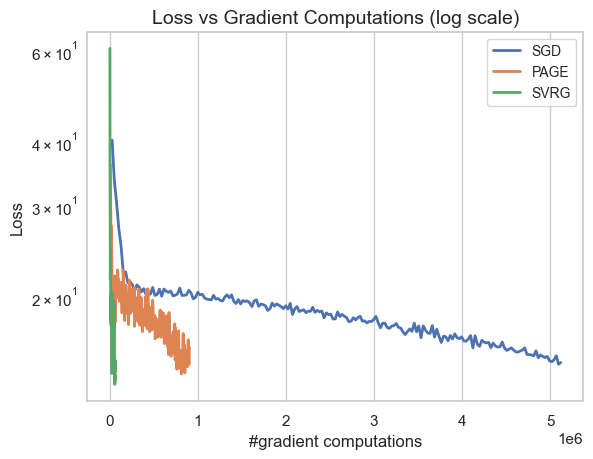

In [104]:
sns.lineplot(x=x_sgd, y=losses_sgd, label='SGD', linewidth=2)
sns.lineplot(x=x_page, y=losses_page, label='PAGE', linewidth=2)
sns.lineplot(x=x_svrg, y=losses_svrg, label='SVRG', linewidth=2)
plt.yscale('log')
plt.xlabel('#gradient computations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Gradient Computations (log scale)', fontsize=14)
plt.legend(fontsize=10)
None

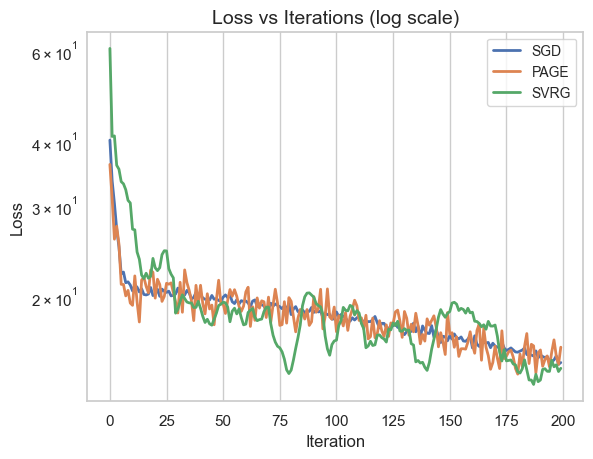

In [105]:
sns.lineplot(data=losses_sgd, label='SGD', linewidth=2)
sns.lineplot(data=losses_page, label='PAGE', linewidth=2)
sns.lineplot(data=losses_svrg, label='SVRG', linewidth=2)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Iterations (log scale)', fontsize=14)
plt.legend(fontsize=10)
None